# Machine Project 7: Intro to Regression Models

#### <span style="color:red">Make sure to read the [README](README.md) before starting this project</span>

## Required Information

Please fill out the following details.  
- Enter your **full name (as it appears on Canvas)** and **NetID**.  
- If you are working in a group (maximum of 4 members), include the **full names and NetIDs** of all your partners.  
- If you're working alone, enter `None` for the partner fields.

> **Important:** Each student must submit the project individually.  
Failure to complete this section may result in your submission being flagged for plagiarism.

In [1]:
# Project: MP7
# Student 1: vardaan kapoor, vkapoor5

## <span style="color:red">Important:</span>

* **Before you begin**, make sure to `pull` any changes from GitLab. From the terminal, run:
```
git checkout main
git pull
git checkout MP7
git merge main
```
* Follow all instructions carefully. If anything is unclear, attend office hours or post on Piazza.
* You may add additional code cells as needed. However, **only cells with `#Q_` in the code will be graded**.
* To test, **Restart and Run all Cells** then **save the notebook** and run `python3 tester.py` from the terminal

> ⚠️ **Reminders:**
>
> - Make sure you are on the `MP7` branch by running `git branch` and checking the output.
> - Frequently `add`, `commit`, and `push` your code to avoid losing progress.


In [2]:
# Add additional imports used throughout the project here

import pickle # used for grading graphs
import os
import pandas as pd
from sklearn.metrics import r2_score
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping
import sqlite3
import numpy as np
import geopandas as gpd
from sklearn.linear_model import LinearRegression
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Group Part (75%)

For this portion of the machine project, you may collaborate with your group members in any way (including looking at group members' code). You may also seek help from CS 320 course staff (peer mentors, TAs, and the instructor). You **may not** seek or receive help from other CS 320 students (outside of your group) or anybody else outside of the course.

## Part 1: Predicting Population using Area
> 📄 **Work in:** [`mp7.ipynb`](mp7.ipynb)

### Q1: How many counties are in Wisconsin?

Read `counties.geojson` into a GeoDataFrame and use it to calculate the number of counties in Wisconsin.

In [3]:
dataset_file="counties.geojson"
df=gpd.read_file(dataset_file)

In [4]:
#Q1
len(df)


72

### Q2: What is the population of each county in WI?

Create a geopandas plot that has a legend using the population from
the `POP100` column.

**Important:** Make sure to pass in `ax` as an argument when plotting: `.plot(ax=ax, ...)`

<img src="img/q2.png" width="500">

The US Census Bureau does some surveys that attempt to sample the
population and others (like the decennial one) that attempt to count
everybody.  "POP100" means this is there attempt to count 100% of the
population (no sampling).  Similarly, "HU100" is a 100% count of
housing units.

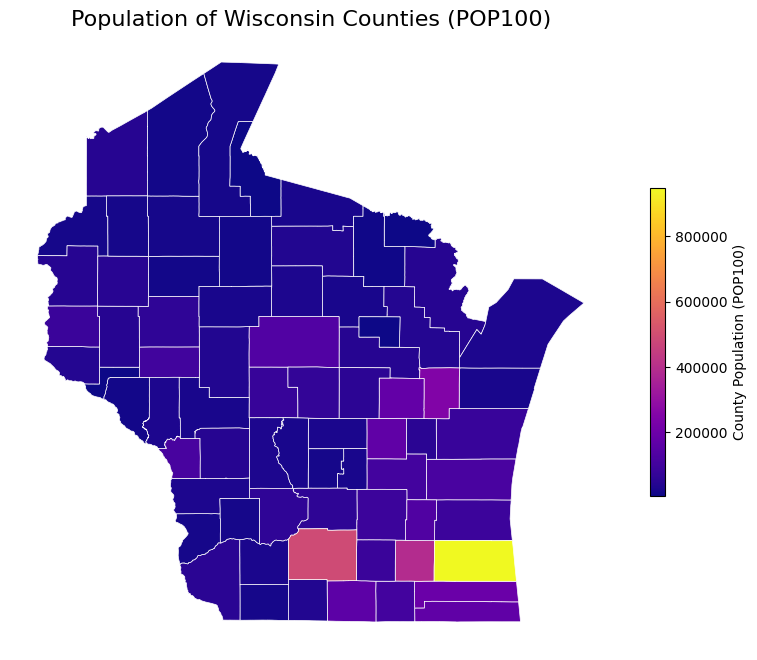

In [5]:
#Q2
fig, ax = plt.subplots(figsize=(10, 8))
df.plot(column="POP100",cmap="plasma",linewidth=0.5,
    edgecolor='white',
    ax=ax,
    legend=True,
    legend_kwds={
        'label': "County Population (POP100)",
        'shrink': 0.5,
        'orientation': 'vertical'
    })
ax.set_title('Population of Wisconsin Counties (POP100)', fontsize=16)
ax.set_axis_off()

# IMPORTANT -- Do not remove -- 
with open("Q2.pkl", "wb") as f:
    pickle.dump(fig, f)

### Requirement: Feature 1 - `AREALAND`

Let's add an `AREALAND` column to your GeoDataFrame of counties so
that we can try to predict population based on area.

You can get the area from the `counties_tracts.db` database.  Open it using [sqlite3](https://docs.python.org/3/library/sqlite3.html) then use [read_sql](https://pandas.pydata.org/docs/reference/api/pandas.read_sql.html) on the DB connection to execute a query.

A great first query for an unfamiliar DB is `pd.read_sql("""SELECT * FROM sqlite_master""", conn)`.  That will show you all the tables the DB has. Try running `pd.read_sql("""SELECT * FROM ????""", conn)` for each table name to see what all the tables look like.

Use data from the database to add an `AREALAND` column to your
GeoDataFrame.  The order of rows in your GeoDataFrame should not
change as part of this operation.

After you've added `AREALAND` to your GeoDataFrame, use
`train_test_split` from `sklearn` to split the rows into `train` and
`test` datasets.

* By default, `train_test_split` randomly shuffles the data differently each time it runs.  Pass `random_state=320` as a parameter so that it shuffles the same way as it did for us (so that you get the answers the tester expects).
* Pass `test_size=0.25` to make the test set be one quarter of the original data and the other three quarters remaining in the training set.


In [6]:
# Feature 1 - AREALAND
con=sqlite3.connect("counties_tracts.db")

In [7]:
countiesTableDetails=pd.read_sql("""SELECT * FROM counties""",con)
print(countiesTableDetails)
nameArea=pd.read_sql("SELECT NAME, AREALAND FROM counties",con)
print(nameArea)
df=df.merge(nameArea,on="NAME",how="left")

    index              NAME COUNTY    AREALAND   AREAWATER
0       0     Racine County    101   861533739  1190103013
1       1      Clark County    019  3133378070    23239614
2       2       Wood County    141  2054044751    41994799
3       3       Rusk County    107  2366092584    44813690
4       4    Ozaukee County    089   603514413  2287415379
..    ...               ...    ...         ...         ...
67     67   Washburn County    129  2064515991   145563849
68     68     Monroe County    081  2333270295    18986835
69     69   Richland County    103  1518120276     8153423
70     70      Price County    099  3248866440    62102368
71     71  St. Croix County    109  1871138853    34271811

[72 rows x 5 columns]
                NAME    AREALAND
0      Racine County   861533739
1       Clark County  3133378070
2        Wood County  2054044751
3        Rusk County  2366092584
4     Ozaukee County   603514413
..               ...         ...
67   Washburn County  2064515991
68   

In [8]:
train_df, test_df = train_test_split(df, test_size=0.25, random_state=320)

### Q3: What are the counties in the test dataset?

Answer with a list, in the same order as the names appear in the original DataFrame. 

In [9]:
#Q3
original_order = df["NAME"].tolist()
test_names_set = set(test_df["NAME"])
test_counties = [name for name in original_order if name in test_names_set]
test_counties

['Clark County',
 'Wood County',
 'Pepin County',
 'Dodge County',
 'Grant County',
 'Milwaukee County',
 'Florence County',
 'Taylor County',
 'Eau Claire County',
 'Sauk County',
 'Iron County',
 'Outagamie County',
 'Oneida County',
 'Pierce County',
 'Ashland County',
 'Kewaunee County',
 'Calumet County',
 'Adams County']

### Q4: How much variance in the `POP100` can a `LinearRegression` model explain based only on `AREALAND`?

`fit` the model to your `train` dataset and `score` it on your `test` dataset. 

**Note:** Calling `LinearRegression.score(...)` will, by default return the $r^2$ score: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.score.

In [10]:
#Q4
x_train=train_df[["AREALAND"]]

y_train=train_df["POP100"]
x_test=test_df[["AREALAND"]]
y_test=test_df["POP100"]

model=LinearRegression()

model.fit(x_train,y_train)
r2score=model.score(x_test,y_test)
r2score

0.022002661530554857

### Q5: What is the predicted population of a county with 300 square miles of area, according to the model?

Consult the [Census documentation](https://tigerweb.geo.census.gov/tigerwebmain/TIGERweb_attribute_glossary.html) to learn what units the data is in, and do any conversions necessary to answer the question.  Assume there are exactly 2.59 square kilometers per square mile for the purposes of your calculation.

**Note:** Make sure to cast the final answer to a `float`.

In [11]:
#Q5
area=300*2.59*1000*1000
area
prediction=model.predict([[area]])[0]
float(prediction)

/home/varda/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


89016.40396725974

## Part 2: Predicting Population using Housing Units
> 📄 **Work in:** [`mp7.ipynb`](mp7.ipynb)

You'll need to wait to do the lab before continuing: [Lab 11](../../labs/Lab11/README.md)

### Requirement: Feature 2 - `HU100` (housing units)

Look at the `tracts` table inside `counties_tracts.db` and find the
`HU100` column. Add a `HU100` column to your GeoDataFrame of counties,
similar to how you added `AREALAND`.

**The query to get housing units per county is more complicated than the
one for AREALAND**.  County names are in the `counties` table and
`HU100` values are in the `tracts` table.  Fortunately, both tables
have a `COUNTY` column you can use to combine. Make sure to get the
total number of housing units for each county from the `tracts` table
by summing the housing units in each tract of the county.

**Split your updated GeoDataFrame into a train and test set, the same
way you did previously.**

**Hints**
1. If I have the same column  in two separate tables, I can run the
following SQL to join based on that column:
```
SELECT table1.column1, column2, column3
FROM table1
INNER JOIN table2
ON table1.column1 == table2.column1
```
2. The order of the counties may not be the same from your original DataFrame
and the one you get from this step. Thus, when you merge them together, consider
using the `pd.merge(...)` function with the `on=????` parameter or the `left_on=????`
and `right_on=????` parameters: https://pandas.pydata.org/docs/reference/api/pandas.merge.html.

In [12]:
# Feature 2 - HU100
pd.read_sql("""SELECT * FROM tracts""", con)
hu_countyName=pd.read_sql("""SELECT counties.NAME,tracts.COUNTY,SUM(HU100) AS HU100
FROM counties
INNER JOIN tracts
ON counties.COUNTY==tracts.COUNTY
GROUP BY tracts.COUNTY
""",con)
print(hu_countyName)
print(df)
df = df.merge(hu_countyName, on="NAME", how="left")
df

                NAME COUNTY   HU100
0       Adams County    001   17436
1     Ashland County    003    9656
2      Barron County    005   23614
3    Bayfield County    007   12999
4       Brown County    009  104371
..               ...    ...     ...
67   Waukesha County    133  160864
68    Waupaca County    135   25396
69   Waushara County    137   14843
70  Winnebago County    139   73329
71       Wood County    141   34088

[72 rows x 3 columns]
                NAME  POP100  \
0      Racine County  195408   
1       Clark County   34690   
2        Wood County   74749   
3        Rusk County   14755   
4     Ozaukee County   86395   
..               ...     ...   
67   Washburn County   15911   
68     Monroe County   44673   
69   Richland County   18021   
70      Price County   14159   
71  St. Croix County   84345   

                                             geometry    AREALAND  
0   POLYGON ((-88.07073 42.66976, -88.06897 42.669...   861533739  
1   POLYGON ((-90.55875 

,NAME,POP100,geometry,AREALAND,COUNTY,HU100
0,Racine County,195408,"POLYGON ((-88.07073 42.66976, -88.06897 42.669...",861533739,101,82164
1,Clark County,34690,"POLYGON ((-90.55875 44.42221, -90.53398 44.422...",3133378070,019,15076
2,Wood County,74749,"POLYGON ((-89.72464 44.33712, -89.7246 44.3384...",2054044751,141,34088
3,Rusk County,14755,"POLYGON ((-90.92517 45.37935, -90.92515 45.379...",2366092584,107,8883
4,Ozaukee County,86395,"POLYGON ((-87.89269 43.19202, -87.89265 43.192...",603514413,089,36267
...,...,...,...,...,...,...
67,Washburn County,15911,"POLYGON ((-91.55065 46.07034, -91.55065 46.070...",2064515991,129,12979
68,Monroe County,44673,"POLYGON ((-90.55246 43.72565, -90.55096 43.725...",2333270295,081,19204
69,Richland County,18021,"POLYGON ((-90.31107 43.55399, -90.31108 43.553...",1518120276,103,8868
70,Price County,14159,"POLYGON ((-90.04485 45.81765, -90.0444 45.8303...",3248866440,099,11120


In [13]:
train_df_hu, test_df_hu = train_test_split(
    df,
    test_size=0.25,
    random_state=320
)

In [14]:
len(train_df_hu)
len(test_df_hu)

18

### Q6: What are the counties in the test dataset?

Answer with a `list`, in the same order as the names appear in the DataFrame.
Note: Refer to [this link](https://www.geeksforgeeks.org/sql-join-set-1-inner-left-right-and-full-joins/) to get a brief understanding on how different joins work.


In [15]:
#Q6
original_order = df["NAME"].tolist()
test_names_set = set(test_df_hu["NAME"])
test_counties_hu = [name for name in original_order if name in test_names_set]
test_counties_hu

['Clark County',
 'Wood County',
 'Pepin County',
 'Dodge County',
 'Grant County',
 'Milwaukee County',
 'Florence County',
 'Taylor County',
 'Eau Claire County',
 'Sauk County',
 'Iron County',
 'Outagamie County',
 'Oneida County',
 'Pierce County',
 'Ashland County',
 'Kewaunee County',
 'Calumet County',
 'Adams County']

### Q7: What are the HU100 values for the counties in the test dataset?

Answer with a `dict`.

In [16]:
#Q7
original_order = df["NAME"].tolist()
test_names_set = set(test_df_hu["NAME"])
test_counties_hu = [name for name in original_order if name in test_names_set]
hu_series = test_df_hu.set_index("NAME")["HU100"]
print(hu_series)
hu_dict = { name: float(hu_series.loc[name]) for name in test_counties_hu }

hu_dict

NAME
Kewaunee County        9304
Calumet County        19695
Adams County          17436
Eau Claire County     42151
Milwaukee County     418053
Ashland County         9656
Wood County           34088
Dodge County          37005
Sauk County           29708
Clark County          15076
Pepin County           3579
Taylor County         10582
Iron County            5999
Outagamie County      73149
Florence County        4780
Oneida County         30125
Pierce County         16132
Grant County          21581
Name: HU100, dtype: int64


{'Clark County': 15076.0,
 'Wood County': 34088.0,
 'Pepin County': 3579.0,
 'Dodge County': 37005.0,
 'Grant County': 21581.0,
 'Milwaukee County': 418053.0,
 'Florence County': 4780.0,
 'Taylor County': 10582.0,
 'Eau Claire County': 42151.0,
 'Sauk County': 29708.0,
 'Iron County': 5999.0,
 'Outagamie County': 73149.0,
 'Oneida County': 30125.0,
 'Pierce County': 16132.0,
 'Ashland County': 9656.0,
 'Kewaunee County': 9304.0,
 'Calumet County': 19695.0,
 'Adams County': 17436.0}

### Q8: How much variance in the `POP100` can a `LinearRegression` model explain based only on `HU100`?

Answer with the average of 5 scores produced by [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) on the training data (i.e., we are doing 5-fold cross validation).

**Note:** Make sure to cast the final answer to a `float`.

In [17]:
#Q8
x_train_hu=train_df_hu[["HU100"]]
y_train_hu=train_df_hu["POP100"]
model_hu=LinearRegression()
cv_scores=cross_val_score(model_hu,x_train_hu,y_train_hu,cv=5)
avg_r2_hu=float(np.mean(cv_scores))
avg_r2_hu

0.9652534544116037

### Q9: What is the standard deviation of the cross validation scores from `Q8`?

Refrain from using statistics.stdev to calculate standard deviation. Variance is the average squared deviations from the mean, while standard deviation is the square root of this number.

**Note:** Make sure to cast the final answer to a `float`.

In [18]:
#Q9
mean_score = np.mean(cv_scores)
variance = np.mean((cv_scores - mean_score) ** 2)
std_dev = float(np.sqrt(variance))

std_dev

0.03704265206670459

### Q10: What is the formula relating POP100 and HU100?

Fit your model to the training dataset to find the answer. Round the coefficient and intercept to 2 decimal places. Format the answer according to the following formula, and output it as a string:

```
POP100 = ????*HU100 + ????
```


In [19]:
#Q10
model_hu.fit(x_train_hu, y_train_hu)
coef=round(model_hu.coef_[0],2)
intercept=round(model_hu.intercept_,2)
formula=f"POP100 = {coef}*HU100 + {intercept}"
formula

'POP100 = 2.39*HU100 + -7910.46'

### Q11: What is the r-squared score of your fitted model (from Q10)?

Use the fitted model from Q10 and [metrics.r2_score()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) from sklearn to find the accuracy of your model. Note that you want to use test data for this question.

In [20]:
#Q11
x_test_hu = test_df_hu[['HU100']]
y_test_hu = test_df_hu['POP100']
y_pred_hu = model_hu.predict(x_test_hu)
r2_test = float(r2_score(y_test_hu, y_pred_hu))

r2_test

0.9958323488562859

### Q12: What is the relationship between HU100 and POP100, visually?

Answer with a scatter plot showing the actual values and the predicted fit line based on the model. You should use both train and test data for the plot (i.e., the entire data).

**_Make sure to include a title and axis labels_**

**Important:** Make sure to pass in `ax` as an argument when plotting: `.plot.line(ax=ax, ...)` / `.plot.scatter(ax=ax, ...)`

Use `.text` to annotate Waukesha County, and a legend to label the actual and predicted parts as in the following. **Do not** add any offset to the `x` or `y` values of the text label

<img src="img/q12.png" width="400">

/home/varda/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


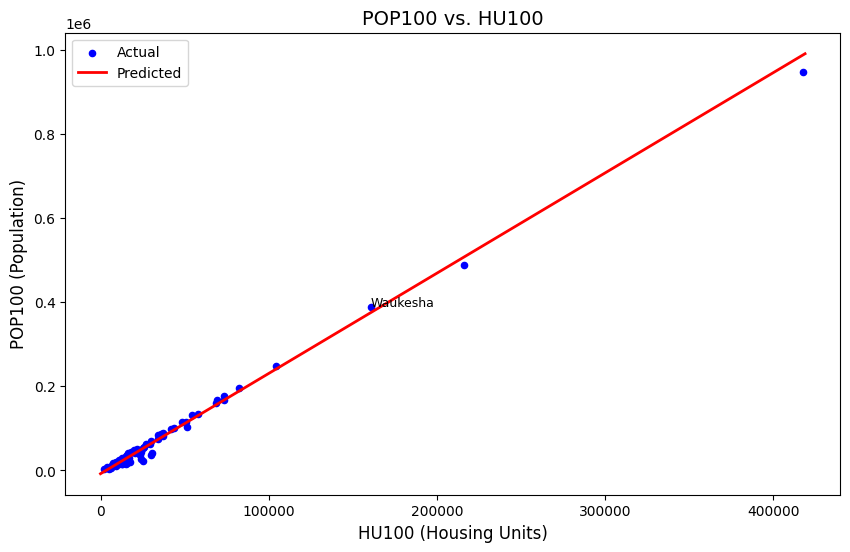

In [21]:
#Q12
fig, ax = plt.subplots(figsize=(10, 6))

# 1) Scatter of the actual data (72 counties)
df.plot.scatter(
    x='HU100',
    y='POP100',
    ax=ax,
    label='Actual',
    color='blue'
)

# 2) Generate exactly 420 HU100 values at 1,000‑unit intervals:
max_hu100 = int(df['HU100'].max())
hu_vals = list(range(0, max_hu100 + 1000, 1000))  
# If max_hu100 is e.g. 419000, this makes [0, 1000, …, 419000] => 420 points

# 3) Predict POP100 at those points
pop_pred = model_hu.predict([[h] for h in hu_vals])

# 4) Plot the red best‑fit line
ax.plot(
    hu_vals,
    pop_pred,
    label='Predicted',
    color='red',
    linewidth=2
)

# 5) Annotate Waukesha County
waukesha = df[df['NAME'] == 'Waukesha County'].iloc[0]
ax.text(
    waukesha['HU100'],
    waukesha['POP100'],
    'Waukesha',
    fontsize=9
)

# 6) Labels, title, legend
ax.set_title('POP100 vs. HU100', fontsize=14)
ax.set_xlabel('HU100 (Housing Units)', fontsize=12)
ax.set_ylabel('POP100 (Population)', fontsize=12)
ax.legend()
# IMPORTANT -- Do not remove -- 
with open("Q12.pkl", "wb") as f:
    pickle.dump(fig, f)

plt.show()

## Part 3: Land Use Features
> 📄 **Work in:** [`mp7.ipynb`](mp7.ipynb)

### Q13: How many numbers in matrix `A` are between 1 and 4 (inclusive)?

The matrix `A` is provided below

**Note:** If you use numpy, make sure to cast the final answer to an `int`.

In [22]:
A = np.array([
    [0,0,5,8,4],
    [1,2,4,0,3],
    [2,4,0,9,2],
    [3,5,2,1,1],
    [0,5,0,1,0]
])

In [23]:
#Q13

mask = (A >= 1) & (A <= 4)
count_between_1_and_4 = int(np.sum(mask))

count_between_1_and_4

13


### Q14: How does Dane County look?

**Note:** in lab, you had to use TIGERweb to get the geodata.  You
**shouldn't** do that here because we already did that saved the results
to `counties.geojson`, which you should use.  Otherwise, this is very
similar to the lab exercise.

You can get the matrix for Dane County using `rasterio` and using the geometry in the DataFrame from `counties.geojson`. You can open a file inside zip by running the command `rasterio.open("zip://./land.zip!/wi.tif")`.

**Note:** Use the color map provided below.

<img src="img/q14.png" width="400">

In [24]:
from matplotlib.colors import ListedColormap

c = np.zeros((256,3))
c[0] = [0.00000000000, 0.00000000000, 0.00000000000]
c[11] = [0.27843137255, 0.41960784314, 0.62745098039]
c[12] = [0.81960784314, 0.86666666667, 0.97647058824]
c[21] = [0.86666666667, 0.78823529412, 0.78823529412]
c[22] = [0.84705882353, 0.57647058824, 0.50980392157]
c[23] = [0.92941176471, 0.00000000000, 0.00000000000]
c[24] = [0.66666666667, 0.00000000000, 0.00000000000]
c[31] = [0.69803921569, 0.67843137255, 0.63921568628]
c[41] = [0.40784313726, 0.66666666667, 0.38823529412]
c[42] = [0.10980392157, 0.38823529412, 0.18823529412]
c[43] = [0.70980392157, 0.78823529412, 0.55686274510]
c[51] = [0.64705882353, 0.54901960784, 0.18823529412]
c[52] = [0.80000000000, 0.72941176471, 0.48627450980]
c[71] = [0.88627450980, 0.88627450980, 0.75686274510]
c[72] = [0.78823529412, 0.78823529412, 0.46666666667]
c[73] = [0.60000000000, 0.75686274510, 0.27843137255]
c[74] = [0.46666666667, 0.67843137255, 0.57647058824]
c[81] = [0.85882352941, 0.84705882353, 0.23921568628]
c[82] = [0.66666666667, 0.43921568628, 0.15686274510]
c[90] = [0.72941176471, 0.84705882353, 0.91764705882]
c[95] = [0.43921568628, 0.63921568628, 0.72941176471]
custom_cmap = ListedColormap(c)

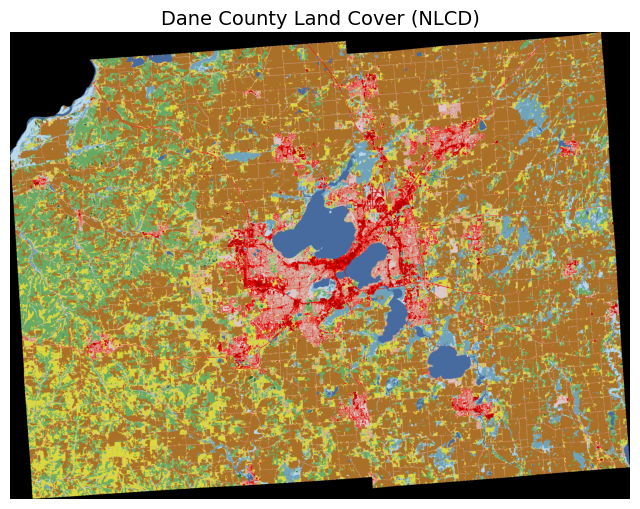

In [25]:
#Q14
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping
import pickle

# Open raster
src = rasterio.open("zip://./land.zip!/wi.tif")

# Pull out Dane County geometry
dane_geom = df[df['NAME'] == 'Dane County'].geometry.iloc[0]

# Reproject Dane geometry to match raster CRS
dane_gs = gpd.GeoSeries([dane_geom], crs=df.crs)
dane_gs = dane_gs.to_crs(src.crs)
dane_geom_raster_crs = dane_gs.iloc[0]

# Mask raster to Dane County
out_image, out_transform = mask(src, [mapping(dane_geom_raster_crs)], crop=True)
dane_matrix = out_image[0]  # Single band

# Plot with custom colormap (define `custom_cmap` before this block)
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(dane_matrix, cmap=custom_cmap, vmin=0, vmax=255)
ax.set_title("Dane County Land Cover (NLCD)", fontsize=14)
ax.set_axis_off()

# Save figure
with open("Q14.pkl", "wb") as f:
    pickle.dump(fig, f)


### Q15: What portion of Dane County is "Crops"?

Be careful!  Not everything in the matrix is Dane County -- cells with value 0 relate to land of other counties and should not be counted.

You can lookup the numeric code for "Crops" and other types here: https://www.mrlc.gov/data/legends/national-land-cover-database-2019-nlcd2019-legend

For your convenience, we have provided the numeric codes below.

**Note:** Make sure to cast the final answer to a `float`.

In [26]:
land_use = {"open_water": 11,
            "ice_snow": 12,
            "developed_open": 21,
            "developed_low": 22,
            "developed_med": 23,
            "developed_high": 24,
            "barren": 31,
            "deciduous": 41,
            "evergreen": 42,
            "mixed_forest": 43,
            "dwarf_scrub": 51,
            "shrub_scrub": 52,
            "grassland": 71,
            "sedge": 72,
            "lichens": 73,
            "moss": 74,
            "pasture": 81,
            "crops": 82,
            "woody_wetlands": 90,
            "herbacious_wetlands": 95}

In [27]:
#Q15

crops_code = land_use["crops"]
dane_county_cells = dane_matrix[dane_matrix != 0]
crops_cells = np.sum(dane_county_cells == crops_code)
total_dane_county_cells = dane_county_cells.size
crops_portion = crops_cells / total_dane_county_cells
float(crops_portion)


0.46705544316564085

### Q16: What is the Relationship Between POP100 and `open_water` cells?

Show a scatter plot where each point corresponds to a county.

**_Make sure to include axis labels_**

**Important:** Make sure to pass in `ax` as an argument when plotting: `.plot.scatter(ax=ax, ...)`

<img src="img/q16.png" width="400">

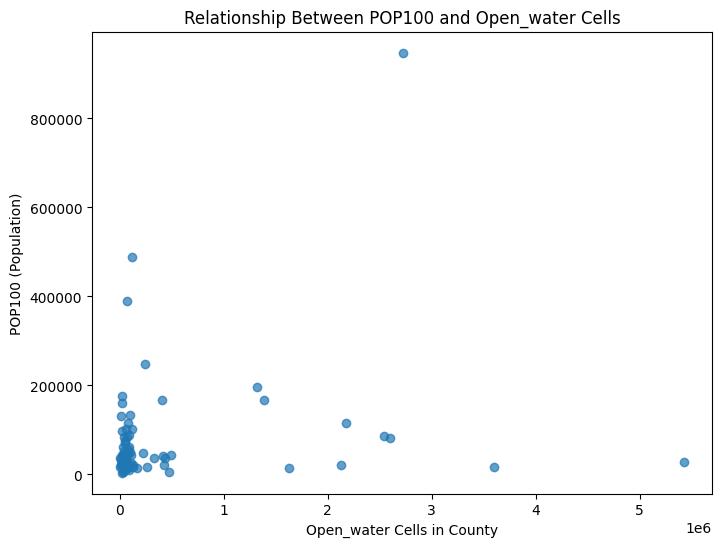

In [28]:
#Q16
chosen_land_type = "open_water"
land_type_code = land_use[chosen_land_type]
land_type_counts = []

with rasterio.open("zip://./land.zip!/wi.tif") as src:
    raster_crs = src.crs
    counties_gdf = df.to_crs(raster_crs)

    for _, county in counties_gdf.iterrows():
        county_geometry = county["geometry"]

        try:
            county_data, county_transform = mask(src, [county_geometry], crop=True, nodata=0)
            county_data = county_data[0]
            count = np.sum(county_data == land_type_code)
        except ValueError:
            count = 0

        land_type_counts.append(count)

# Add column with crop cell counts
counties_gdf[f"{chosen_land_type}_cells"] = land_type_counts

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(counties_gdf[f"{chosen_land_type}_cells"], counties_gdf["POP100"], alpha=0.7)
ax.set_title(f"Relationship Between POP100 and {chosen_land_type.capitalize()} Cells")
ax.set_xlabel(f"{chosen_land_type.capitalize()} Cells in County")
ax.set_ylabel("POP100 (Population)")  # <-- Fix: y-label added to ax object

# IMPORTANT -- Do not remove --
with open("Q16.pkl", "wb") as f:
    pickle.dump(fig, f)


# Individual Part (25%)

For this portion of the machine project, you are only allowed to seek help from CS 320 course staff (peer mentors, TAs, and the instructor). You **may not** receive help from anyone else.

For this part, you'll try to predict population on a **per-census
tract** basis (in contrast to our preceding per-county analysis),
using features calculated from the land use data. 

## Part 4: Feature Analysis
> 📄 **Work in:** [`mp7.ipynb`](mp7.ipynb)

1. Start with a GeoDataFrame dataset loaded from `tracts.shp`.
2. Add feature columns to that dataset for every key in land_use(found under q14), with the column value being the number of units present of that land type, based on raster data from `lands.zip`.
**Important:** Computation takes considerable amount of time with raster data so try to minimize masking operations!
3. Split your GeoDataFrame into train/test using `random_state=320` and `test_size=0.20`.
4. Construct a regression model to predict POP100. Use all of the new columns you created in step 2 as the features for training.

In [29]:
# Part 1

### Q17: What features does your model rely on most?

Answer with a bar plot showing feature and coefficient of feature in our trained model.

Write a comment discussing what the graph is showing you and how you might use that 
information in building your own model

**Important:** Make sure to pass in `ax` as an argument when plotting: `.plot.bar(ax=ax)`

**This question is weighted to be worth 2 regular questions.**

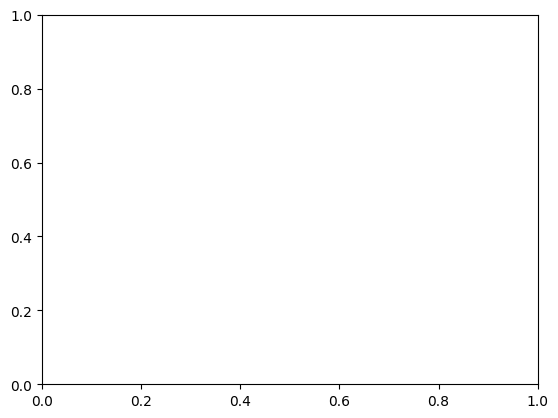

In [30]:
#Q17
fig, ax = plt.subplots()

# PLOT HERE

# IMPORTANT -- Do not remove -- 
with open("Q17.pkl", "wb") as f:
    pickle.dump(fig, f)
    
plt.show()

## Part 5: Model Creation and Analysis
1. Construct at least 2 regression models predicting POP100. They should differ in terms of (a) what columns they use and/or (b) whether or not they're preceded by transformers in an sklearn Pipeline
2. Perform cross validation on both of your models over your training dataset

In [31]:
# Part 2

### Q18: What is the mean and variance of the cross validation scores from both of your models?

Answer with a dictionary like this:
```
{
'model1-avg': 0.44286680823801083,
 'model1-std': 0.034903979417578036,
 'model2-avg': 0.4746679087375649,
 'model2-std': 0.033400327309278784
}
```

Write a comment recommending which model you recommend for this prediction task. Factors you **must** consider are (a) mean of cross validation scores is high, (b) variance of cross validation scores is low. Additional factors you might consider are (c) model is simple, and (d) anything else you think is important.

**Note:** Your values are likely to be different than those seen above, which is okay.
We are just checking if you return a dictionary for this question.

In [32]:
#Q18

<hr/>

#### Write answer here

<hr/>

### Q19: How does your recommended model score against the test dataset?

Fit your recommended model to the train dataset and then score it using the test dataset.
Your model needs to achieve explained variance higher than 0.35 in order to receive full credit.

**This question is weighted to be worth 3 regular questions.**

In [33]:
#Q19

## <span style="color:red">Important:</span>
Make sure to follow these steps to submit the project
1. **Kernel > Restart Kernel and Run All Cells** and then save the notebook
2. Run `tester.py` to check your answers
3. Run the following commands from the terminal:
```
git status # make sure you are in the correct branch
git add <required files>
git commit -m "Some message"
git push
```
4. Once you've pushed your project to GitLab, **verify that the pipeline ran successfully**.
    * Build > Jobs > Select the latest commit hash > Check tester output
5. Create a **_merge request_** to submit the project
    * Code > Merge requests > New merge request